In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import joblib
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score


In [3]:
df = pd.read_csv("car_data.csv")
df

,Car_Name,Year,Selling_Price,Present_Price,Driven_kms,Fuel_Type,Selling_type,Transmission,Owner
0,ritz,2014,3.35,5.59,27000,Petrol,Dealer,Manual,0
1,sx4,2013,4.75,9.54,43000,Diesel,Dealer,Manual,0
2,ciaz,2017,7.25,9.85,6900,Petrol,Dealer,Manual,0
3,wagon r,2011,2.85,4.15,5200,Petrol,Dealer,Manual,0
4,swift,2014,4.60,6.87,42450,Diesel,Dealer,Manual,0
...,...,...,...,...,...,...,...,...,...
296,city,2016,9.50,11.60,33988,Diesel,Dealer,Manual,0
297,brio,2015,4.00,5.90,60000,Petrol,Dealer,Manual,0
298,city,2009,3.35,11.00,87934,Petrol,Dealer,Manual,0
299,city,2017,11.50,12.50,9000,Diesel,Dealer,Manual,0


In [4]:
current_year = df['Year'].max() + 1
df['Car_Age'] = current_year - df['Year']
df['Brand'] = df['Car_Name'].str.split().str[0]

In [5]:
features = ['Present_Price', 'Driven_kms', 'Car_Age', 'Fuel_Type', 'Selling_type', 'Transmission', 'Brand']
target = 'Selling_Price'

X = df[features]
y = df[target]

In [6]:
cat_cols = ['Fuel_Type', 'Selling_type', 'Transmission', 'Brand']
num_cols = ['Present_Price', 'Driven_kms', 'Car_Age']

preprocessor = ColumnTransformer(
    transformers=[
        ('cat', OneHotEncoder(handle_unknown='ignore'), cat_cols)
    ],
    remainder='passthrough'
)

In [7]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [8]:
models = {
    "Linear Regression": LinearRegression(),
    "Ridge Regression": Ridge(alpha=1.0),
    "Lasso Regression": Lasso(alpha=0.01),
    "Decision Tree": DecisionTreeRegressor(random_state=42),
    "Random Forest": RandomForestRegressor(random_state=42, n_estimators=100),
    "Gradient Boosting": GradientBoostingRegressor(random_state=42, n_estimators=100)
}

results = []


In [9]:
for name, model in models.items():
    print(f"\nTraining {name}...")
    pipe = Pipeline(steps=[
        ('preprocessor', preprocessor),
        ('model', model)
    ])


    cv_r2 = cross_val_score(pipe, X_train, y_train, cv=5, scoring='r2')
    cv_mae = cross_val_score(pipe, X_train, y_train, cv=5, scoring='neg_mean_absolute_error')

    print(f"{name} CV R2 (mean ± std): {cv_r2.mean():.4f} ± {cv_r2.std():.4f}")
    print(f"{name} CV MAE (mean ± std): {-cv_mae.mean():.4f} ± {cv_mae.std():.4f}")


    pipe.fit(X_train, y_train)
    y_pred = pipe.predict(X_test)

    mae = mean_absolute_error(y_test, y_pred)
    rmse = mean_squared_error(y_test, y_pred) ** 0.5
    r2 = r2_score(y_test, y_pred)

    print(f"{name} Test MAE: {mae:.4f}, RMSE: {rmse:.4f}, R2: {r2:.4f}")
    results.append((name, r2, mae, rmse, pipe))


Training Linear Regression...
Linear Regression CV R2 (mean ± std): 0.8533 ± 0.0156
Linear Regression CV MAE (mean ± std): 1.1668 ± 0.1473
Linear Regression Test MAE: 1.0826, RMSE: 1.6792, R2: 0.8776

Training Ridge Regression...
Ridge Regression CV R2 (mean ± std): 0.8471 ± 0.0486
Ridge Regression CV MAE (mean ± std): 1.2241 ± 0.1064
Ridge Regression Test MAE: 1.3227, RMSE: 1.9635, R2: 0.8326

Training Lasso Regression...
Lasso Regression CV R2 (mean ± std): 0.8381 ± 0.0231
Lasso Regression CV MAE (mean ± std): 1.1220 ± 0.1459
Lasso Regression Test MAE: 1.0392, RMSE: 1.6008, R2: 0.8888

Training Decision Tree...
Decision Tree CV R2 (mean ± std): 0.8534 ± 0.1122
Decision Tree CV MAE (mean ± std): 0.7398 ± 0.1937
Decision Tree Test MAE: 0.6325, RMSE: 1.0135, R2: 0.9554

Training Random Forest...
Random Forest CV R2 (mean ± std): 0.8877 ± 0.0562
Random Forest CV MAE (mean ± std): 0.6863 ± 0.0760
Random Forest Test MAE: 0.6169, RMSE: 0.9018, R2: 0.9647

Training Gradient Boosting...
Grad

In [10]:
model_names = [r[0] for r in results]
r2_scores = [r[1] for r in results]

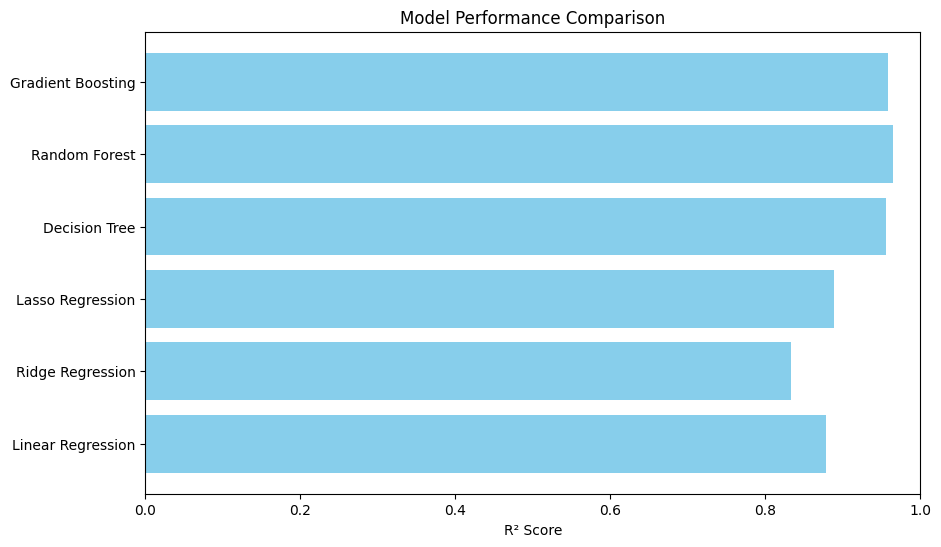

In [11]:
plt.figure(figsize=(10,6))
plt.barh(model_names, r2_scores, color='skyblue')
plt.xlabel("R² Score")
plt.title("Model Performance Comparison")
plt.xlim(0, 1)
plt.show()

In [12]:
best_model_info = max(results, key=lambda x: x[1])
best_model_name, best_r2, _, _, best_pipeline = best_model_info
print(f"\nBest Model: {best_model_name} with R² = {best_r2:.4f}")



Best Model: Random Forest with R² = 0.9647


In [13]:
joblib.dump(best_pipeline, "best_car_price_model.pkl")
print("Best model saved as 'best_car_price_model.pkl'")

Best model saved as 'best_car_price_model.pkl'
